<a href="https://colab.research.google.com/github/heejipark/Research-PPG2ABP-using-GAN/blob/dev/06_change_model_size_with_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Preprocessing

In [2]:
!pip install vitaldb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check time
from tqdm import tqdm
from time import sleep

# Datasets
import vitaldb
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import Adam
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets
import torchvision.utils as vutils
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F

# For model
import argparse
import itertools

from tqdm import tqdm
import time

%matplotlib inline

cachefile = '/content/drive/MyDrive/snuh/ppg_abp_datasets_peak_50_with_filter.npz'

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

In [4]:
ppg_abp_sets = np.load(cachefile)       # Load cache file
ppg_sets = ppg_abp_sets['ppg_sets']
abp_sets = ppg_abp_sets['abp_sets']
ppg_abp_sets.close()                    # For memory efficiency, close the file

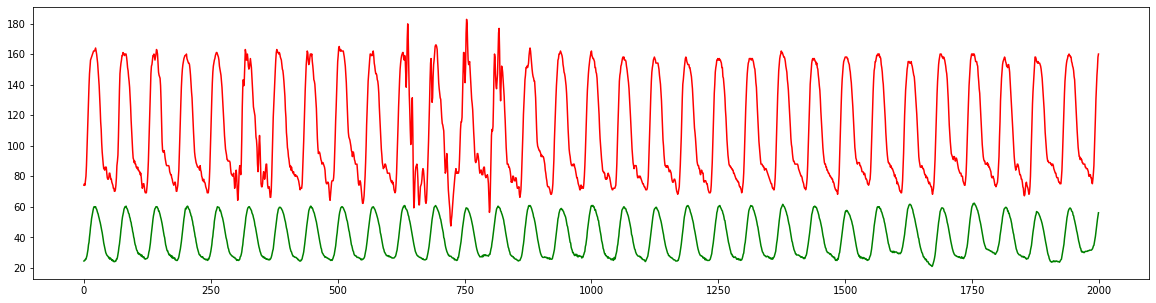

In [5]:
#### Before Preprocessing ------------------------------------
# Draw a sample waveform for PPG
plt.figure(figsize=(20,5))
plt.plot(ppg_sets[2], color='g', label='PPG')
plt.plot(abp_sets[2], color='r', label='ABP')

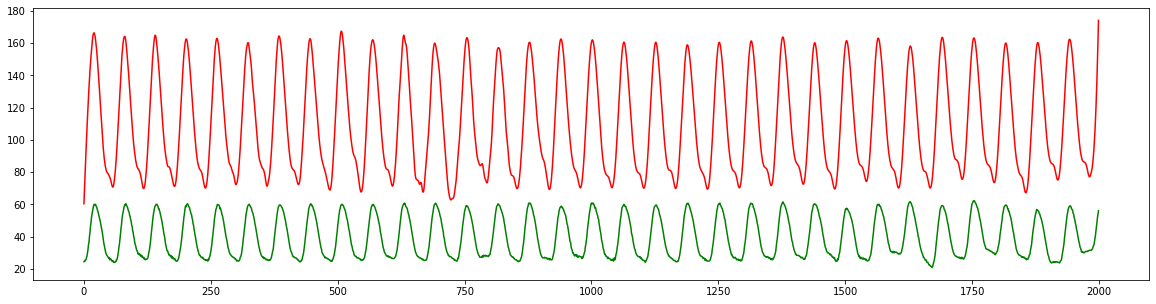

In [6]:
#### After Preprocessing ------------------------------------
from scipy.signal import savgol_filter
abp_sets = savgol_filter(abp_sets, 31, 3)
plt.figure(figsize=(20,5))
plt.plot(ppg_sets[2], color='g', label='PPG')
plt.plot(abp_sets[2], color='r', label='ABP')

In [7]:
# Shape of data ----------------------------
print(ppg_sets.shape)
print(abp_sets.shape)

(24137, 2000)
(24137, 2000)


In [8]:
ppg_sets = ppg_sets[:24000]
abp_sets = abp_sets[:24000]

## Hyperparameter

In [9]:
# Make a directory to save the model for further use
MODEL_ID = 'train'
MODEL_SAVE_PATH = "/outputs/" + MODEL_ID
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
epoch = 0            # starting epoch
n_epochs = 30         # number of epochs of training
batch_size = 32      # size of the batches
lr = 1e-4            # initial learning rate
decay_epoch = 100    # epoch to start linearly decaying the learning rate to 0
workers = 2          # number of workers
input_nc = 1         # number of channels of input data
output_nc = 1        # number of channels of output data
beta1 = 1            # beta1 value for Adam optimizer
seed = 30            # random seed


# LR schedulers
#lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
#lr_scheduler_D_P2A = optim.lr_scheduler.LambdaLR(optimizer_D_P2A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
#lr_scheduler_D_A2P = optim.lr_scheduler.LambdaLR(optimizer_D_A2P, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Model parameters
# It is for commend line
# parser = argparse.ArgumentParser()
# parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
# parser.add_argument('--n_epochs', type=int, default=10, help='number of epochs of training')
# parser.add_argument('--batch_size', type=int, default=64, help='size of the batches')
# parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
# parser.add_argument('--decay_epoch', type=int, default=100, help='epoch to start linearly decaying the learning rate to 0')
# parser.add_argument('--workers', type=int, default=2, help='the number of workers')
# parser.add_argument('--input_nc', type=int, default=1, help='number of channels of input data')
# parser.add_argument('--output_nc', type=int, default=1, help='number of channels of output data')
# parser.add_argument('--beta1', type=int, default=1, help='betal value for Adam optimizer')
# parser.add_argument('--seed', type=int, default=30, help='random seed')
# opt = parser.parse_args()
# print(opt)

## Dataloader

In [10]:
## Min-Max Normalization
def findMinMax(datasets):
  return (np.max(datasets), np.min(datasets))

def minMax(datasets):
  maxVal, minVal = findMinMax(datasets)
  normVal = (datasets - minVal) / (maxVal - minVal)

  return normVal

In [11]:
# Split data into training and testing datasets
ppg_train, ppg_test, abp_train, abp_test = train_test_split(ppg_sets, abp_sets, test_size=0.2, random_state=25)

# Normalization
norm_ppg_train, norm_ppg_test  = minMax(ppg_train), minMax(ppg_test)
norm_abp_train, norm_abp_test  = minMax(abp_train), minMax(abp_test)

# Change data type
norm_ppg_train = torch.tensor(norm_ppg_train, dtype=torch.float32)
norm_ppg_test = torch.tensor(norm_ppg_test, dtype=torch.float32)
norm_abp_train = torch.tensor(norm_abp_train, dtype=torch.float32)
norm_abp_test = torch.tensor(norm_abp_test, dtype=torch.float32)

# Make the datasets as a TensorDataset
ds_train = TensorDataset(norm_ppg_train, norm_abp_train)
ds_test = TensorDataset(norm_ppg_test, norm_abp_test)

# Create the dataloader
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=workers)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=workers)

In [12]:
ppg_train.shape # (batch size, dim)

(19200, 2000)

## Model

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        layer = [nn.ReflectionPad1d(1),
                 nn.Conv1d(in_features, in_features, 3),
                 nn.InstanceNorm1d(in_features),
                 nn.ReLU(inplace=True),
                 nn.ReflectionPad1d(1),
                 nn.Conv1d(in_features, in_features, 3),
                 nn.InstanceNorm1d(in_features)]
        
        self.conv_block = nn.Sequential(*layer)

    def forward(self, x):
        return x + self.conv_block(x)

1. Generator(Encoder)
    -> C32, C64, C128, C128, C128, C128, C128, C128, C128, C128, C128, C128
2. Generator(Decoder)
    -> C128, C64, C32
3. Discriminator
    -> C32 - C64 - C128 - C256 - C1

In [14]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
    
        # Initial convolution block       
        self.model1 = nn.Sequential(
                 nn.ReflectionPad1d(1),
                 nn.Conv1d(input_nc, 32, 3, stride=1)
                 )

        # Encoder - Downsampling
        in_features = 32
        out_features = in_features*2
        model2 = []
        for _ in range(2):
            model2 += [nn.Conv1d(in_features, out_features, 3, stride=1),
                       nn.InstanceNorm1d(out_features),
                       nn.LeakyReLU(0.2, inplace=True)]
            in_features = out_features
            out_features = in_features*2
        self.model2 = nn.Sequential(*model2)
        
        model3=[]
        # Residual blocks
        for _ in range(n_residual_blocks):
            model3 += [ResidualBlock(in_features)]
        self.model3 = nn.Sequential(*model3)
        
        # Decoder - Upsampling
        model4 = []
        out_features = in_features//2
        for _ in range(2):
            model4 += [nn.ConvTranspose1d(in_features, out_features, 3, stride=1),
                      nn.InstanceNorm1d(out_features),
                      nn.LeakyReLU(0.2, inplace=True)]
            in_features = out_features
            out_features = in_features//2
        self.model4 = nn.Sequential(*model4)
        
        # Output layer
        self.model5 = nn.Sequential(
                  nn.ReflectionPad1d(1),
                  nn.Conv1d(32, output_nc, 3, stride=1))

    def forward(self, x):
        x = self.model1(x) 
        x = self.model2(x)
        x = self.model3(x)
        x = self.model4(x)
        out = self.model5(x)
        return out

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [nn.Conv1d(input_nc, 32, 1),
                 nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.Conv1d(32, 64, 1),
                  nn.InstanceNorm1d(64), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv1d(64, 128, 1),
                  nn.InstanceNorm1d(256), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv1d(128, 256, 1),
                  nn.InstanceNorm1d(512), 
                  nn.LeakyReLU(0.2, inplace=True)]

        # FCN classification layer
        model += [nn.Conv1d(256, 1, 1)]
        model += [nn.ELU()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool1d(x, x.size()[2:]).view(x.size()[0], -1)

In [16]:
# Initalize Generator and Discriminator
netG_P2A = Generator(input_nc, output_nc).to(device)
netG_A2P = Generator(output_nc, input_nc).to(device)
netD_PPG = Discriminator(input_nc).to(device)
netD_ABP = Discriminator(input_nc).to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm1d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


# need Weight Initialization
netG_P2A.apply(weights_init_normal)
netG_A2P.apply(weights_init_normal)
netD_PPG.apply(weights_init_normal)
netD_ABP.apply(weights_init_normal)

# Optimizers
optimizer_G = optim.Adam(itertools.chain(netG_P2A.parameters(), netG_A2P.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_PPG = optim.Adam(netD_ABP.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_ABP = optim.Adam(netD_PPG.parameters(), lr=lr, betas=(0.5, 0.999))

# Cross-function
criterion_gan = nn.MSELoss().to(device)      # How the discriminator discriminates the data whether it is generated or not
criterion_identity = nn.L1Loss().to(device)  # How different the generated data is from the original data through forward OR backward transformations
criterion_cycle = nn.L1Loss().to(device)     # How different the generated data is from the original data through forward AND backward transformations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.


In [17]:
print(netG_P2A)
print(netD_PPG)

Generator(
  (model1): Sequential(
    (0): ReflectionPad1d((1, 1))
    (1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  )
  (model2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model3): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad1d((1, 1))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
        (2): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad1d((1, 1))
        (5): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
        (6): InstanceNorm1d(128, 

## Train

In [18]:
for epoch in range(epoch, n_epochs):
    print("%d epoch-------------------------------"%(epoch+1))
    for real_ppg, real_abp in tqdm(loader_train):
        time.sleep(0.01)
        #########################################
        # Generator PPG2ABP and ABP2PPG
        # 1. GAN loss
        # 2. Cycle loss
        # 3. Identity loss
        # 4. Total loss
        #########################################
        

        # Forward------------------------------------------
        # Transform the datasets
        real_ppg_3d = real_ppg.unsqueeze(0).transpose(0,1).to(device)
        real_abp_3d = real_abp.unsqueeze(0).transpose(0,1).to(device)
        
        # 1. Generate fake data
        fake_abp = netG_P2A(real_ppg_3d)
        fake_ppg = netG_A2P(real_abp_3d)

        recovered_ppg = netG_A2P(fake_abp)
        recovered_abp = netG_P2A(fake_ppg)
        
        identity_abp = netG_P2A(real_abp_3d)
        identity_ppg = netG_A2P(real_ppg_3d)
        
        
        # Backward generator path --------------------------
        discFakeppg = netD_PPG(fake_ppg)
        discFakeabp = netD_ABP(fake_abp)
        discCycleppg = netD_PPG(recovered_ppg)
        discCycleabp = netD_ABP(recovered_abp)
        
        
        # 1. GAN loss
        loss_ppg = criterion_gan(discFakeppg, real_ppg_3d)
        loss_abp = criterion_gan(discFakeabp, real_abp_3d)
        
        
        # 2. Cycle loss
        loss_cycle_abp = criterion_cycle(recovered_abp, real_abp_3d)
        loss_cycle_ppg = criterion_cycle(recovered_ppg, real_ppg_3d)
        
        # 3. Identity loss
        loss_identity_ppg = criterion_identity(identity_ppg, real_ppg_3d)
        loss_identity_abp = criterion_identity(identity_abp, real_abp_3d)
        
        
        # 4. Total loss = GAN loss + Cycle loss + Identity loss
        loss_G = (loss_ppg + loss_abp) + \
                 (loss_identity_ppg + loss_identity_abp) * 5.0 + \
                 (loss_cycle_ppg + loss_cycle_abp) * 10.0
        
        optimizer_G.zero_grad()
        loss_G.backward()   # Calculates the loss of the loss function
        optimizer_G.step()
        
        
        # Backward generator path --------------------------
        
        discFakeppg = netD_PPG(fake_ppg.detach())
        discRealppg = netD_PPG(real_ppg_3d)
        
        loss_D_Real_ppg = criterion_gan(discFakeppg, torch.ones_like(discFakeppg))
        loss_D_Fake_ppg = criterion_gan(discRealppg, torch.zeros_like(discRealppg))
                        
        loss_D_PPG = (loss_D_Real_ppg + loss_D_Fake_ppg) * 0.5
        optimizer_D_PPG.zero_grad()
        loss_D_PPG.requires_grad_(True)
        loss_D_PPG.backward()
        optimizer_D_PPG.step()
        
        discFakeabp = netD_ABP(fake_abp.detach())
        discRealabp = netD_ABP(real_abp_3d)
        
        loss_D_Real_abp = criterion_gan(discFakeabp, torch.ones_like(discFakeabp))
        loss_D_Fake_abp = criterion_gan(discRealabp, torch.zeros_like(discRealabp))
        
        loss_D_ABP = (loss_D_Real_abp + loss_D_Fake_abp) * 0.5
        optimizer_D_ABP.zero_grad()
        loss_D_ABP.requires_grad_(True)
        loss_D_ABP.backward()
        optimizer_D_ABP.step()
      
    # Print loss
    print("Epoch [{}/{}], loss_G: {:.4f}, loss_D_ABP: {:.4f}, loss_D_PPG: {:.4f}".format(
           epoch+1, n_epochs, loss_G, loss_D_ABP, loss_D_PPG))


    # Save models checkpoints
    torch.save(netG_P2A.state_dict(), '/content/drive/MyDrive/snuh/output/reduce/model/netG_A2B.pth')
    torch.save(netG_A2P.state_dict(), '/content/drive/MyDrive/snuh/output/reduce/model/netG_B2A.pth')
    torch.save(netD_ABP.state_dict(), '/content/drive/MyDrive/snuh/output/reduce/model/netD_A.pth')
    torch.save(netD_PPG.state_dict(), '/content/drive/MyDrive/snuh/output/reduce/model/netD_B.pth')

1 epoch-------------------------------


  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 2000])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [1/30], loss_G: 1.1607, loss_D_ABP: 0.3522, loss_D_PPG: 0.4412
2 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [2/30], loss_G: 0.9289, loss_D_ABP: 0.3554, loss_D_PPG: 0.4365
3 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [3/30], loss_G: 0.8302, loss_D_ABP: 0.3554, loss_D_PPG: 0.4343
4 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [4/30], loss_G: 0.7796, loss_D_ABP: 0.3550, loss_D_PPG: 0.4333
5 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [5/30], loss_G: 0.8033, loss_D_ABP: 0.3556, loss_D_PPG: 0.4328
6 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [6/30], loss_G: 0.7626, loss_D_ABP: 0.3546, loss_D_PPG: 0.4332
7 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [7/30], loss_G: 0.7194, loss_D_ABP: 0.3537, loss_D_PPG: 0.4326
8 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [8/30], loss_G: 0.7053, loss_D_ABP: 0.3534, loss_D_PPG: 0.4325
9 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [9/30], loss_G: 0.6831, loss_D_ABP: 0.3537, loss_D_PPG: 0.4320
10 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [10/30], loss_G: 0.6265, loss_D_ABP: 0.3525, loss_D_PPG: 0.4325
11 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [11/30], loss_G: 0.6614, loss_D_ABP: 0.3528, loss_D_PPG: 0.4320
12 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [12/30], loss_G: 0.6236, loss_D_ABP: 0.3517, loss_D_PPG: 0.4317
13 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [13/30], loss_G: 0.6246, loss_D_ABP: 0.3519, loss_D_PPG: 0.4311
14 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [14/30], loss_G: 0.5897, loss_D_ABP: 0.3515, loss_D_PPG: 0.4311
15 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [15/30], loss_G: 0.6049, loss_D_ABP: 0.3511, loss_D_PPG: 0.4305
16 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [16/30], loss_G: 0.6083, loss_D_ABP: 0.3518, loss_D_PPG: 0.4307
17 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [17/30], loss_G: 0.5620, loss_D_ABP: 0.3498, loss_D_PPG: 0.4303
18 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [18/30], loss_G: 0.5876, loss_D_ABP: 0.3505, loss_D_PPG: 0.4302
19 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [19/30], loss_G: 0.5704, loss_D_ABP: 0.3496, loss_D_PPG: 0.4301
20 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [20/30], loss_G: 0.5355, loss_D_ABP: 0.3499, loss_D_PPG: 0.4302
21 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]


Epoch [21/30], loss_G: 0.5244, loss_D_ABP: 0.3499, loss_D_PPG: 0.4296
22 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [22/30], loss_G: 0.5354, loss_D_ABP: 0.3497, loss_D_PPG: 0.4297
23 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [23/30], loss_G: 0.5199, loss_D_ABP: 0.3493, loss_D_PPG: 0.4295
24 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [24/30], loss_G: 0.5358, loss_D_ABP: 0.3501, loss_D_PPG: 0.4293
25 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [25/30], loss_G: 0.5318, loss_D_ABP: 0.3493, loss_D_PPG: 0.4295
26 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [26/30], loss_G: 0.5089, loss_D_ABP: 0.3490, loss_D_PPG: 0.4293
27 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [27/30], loss_G: 0.5157, loss_D_ABP: 0.3488, loss_D_PPG: 0.4293
28 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [28/30], loss_G: 0.4951, loss_D_ABP: 0.3491, loss_D_PPG: 0.4295
29 epoch-------------------------------


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Epoch [29/30], loss_G: 0.5136, loss_D_ABP: 0.3484, loss_D_PPG: 0.4287
30 epoch-------------------------------


100%|██████████| 600/600 [07:39<00:00,  1.30it/s]

Epoch [30/30], loss_G: 0.4672, loss_D_ABP: 0.3494, loss_D_PPG: 0.4292


In [19]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [20]:
print(recovered_abp.shape, real_abp_3d.shape)
print(recovered_ppg.shape, real_ppg_3d.shape)

torch.Size([32, 1, 2000]) torch.Size([32, 1, 2000])
torch.Size([32, 1, 2000]) torch.Size([32, 1, 2000])


## Test

In [21]:
###### Test ######

dataNum = 1
for real_ppg, real_abp in loader_test:
    # Set model input
    real_ppg_3d = real_ppg.unsqueeze(0).transpose(0,1).to(device)
    real_abp_3d = real_abp.unsqueeze(0).transpose(0,1).to(device)

    # Generate output
    fake_abp = netG_P2A(real_ppg_3d).data
    fake_ppg = netG_A2P(real_abp_3d).data
    
    # Find min-max value from test datasets
    max_ppg, min_ppg = findMinMax(ppg_test)
    max_abp, min_abp = findMinMax(abp_test)

    # Revert the data from normalized one
    revert_real_abp = real_abp_3d * (max_abp - min_abp) + min_abp
    revert_real_ppg = real_ppg_3d * (max_ppg - min_ppg) + min_ppg
    revert_fake_abp = fake_abp * (max_abp - min_abp) + min_abp
    revert_fake_ppg = fake_ppg * (max_ppg - min_ppg) + min_ppg

    # Save data file 
    resultfile ='/content/drive/MyDrive/snuh/output/reduce/data/temp_data%d.npz'%(dataNum)
    np.savez(resultfile, real_abp=revert_real_abp.squeeze().cpu(), fake_abp=revert_fake_abp.squeeze().cpu(), 
             real_ppg=revert_real_ppg.squeeze().cpu(), fake_ppg=revert_fake_ppg.squeeze().cpu()) # Save cahce file
    dataNum += 1

## Draw a graph

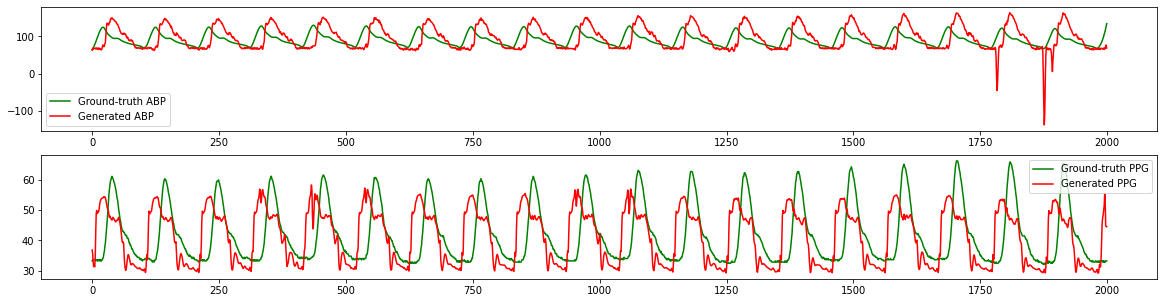

In [22]:
result = np.load('/content/drive/MyDrive/snuh/output/reduce/data/temp_data1.npz')
real_abp_sets = result['real_abp']
real_ppg_sets = result['real_ppg']

fake_abp_sets = result['fake_abp']
fake_ppg_sets = result['fake_ppg']

plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(real_abp_sets[0], color='g', label='Ground-truth ABP')
plt.plot(fake_abp_sets[0], color='r', label='Generated ABP')
plt.legend()


plt.subplot(2,1,2)
plt.plot(real_ppg_sets[0], color='g', label='Ground-truth PPG')
plt.plot(fake_ppg_sets[0], color='r', label='Generated PPG')
plt.legend()

plt.savefig('/content/drive/MyDrive/snuh/output/reduce/graph/ppg_abp.png')

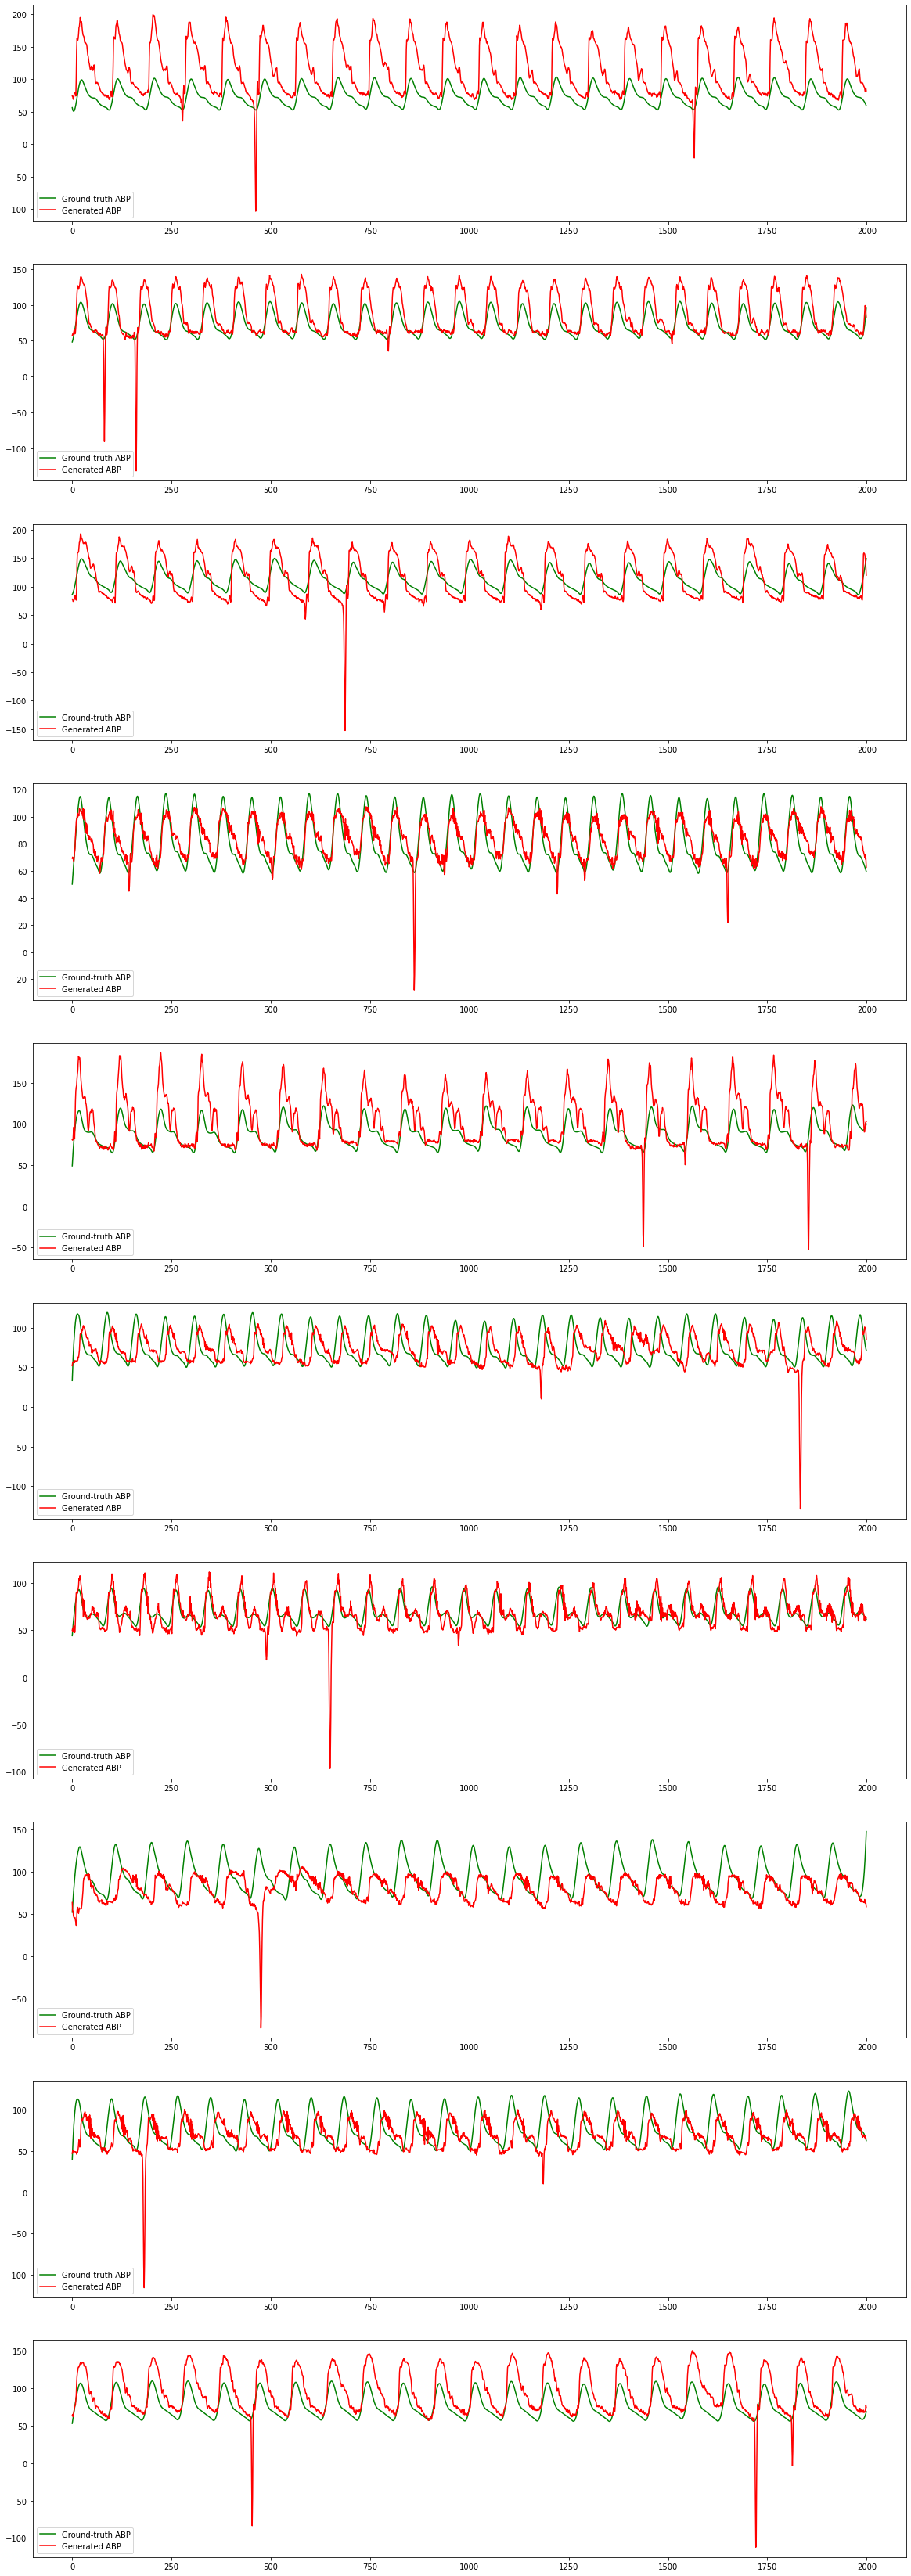

In [23]:
plt.figure(figsize=(20,60))
for i in range(1,11):
  plt.subplot(10,1,i)
  plt.plot(real_abp_sets[i], color='g', label='Ground-truth ABP')
  plt.plot(fake_abp_sets[i], color='r', label='Generated ABP')
  plt.legend()

plt.savefig('/content/drive/MyDrive/snuh/output/reduce/graph/compared_abp.png')

In [24]:
print(real_abp_sets[9])
print(np.max(real_abp_sets[9]), np.min(real_abp_sets[9]))
print(fake_abp_sets[9])
print(np.max(fake_abp_sets[9]), np.min(fake_abp_sets[9]))

print(sorted(fake_abp_sets[9])[:20])

[39.758415 52.089497 63.070717 ... 66.21566  64.47436  62.49613 ]
122.59659 39.758415
[47.09204  49.974007 51.18441  ... 68.585266 65.324875 64.66508 ]
100.471115 -115.49034
[-115.49034, -88.89572, -88.40425, -32.705627, -30.84418, 10.25416, 14.133432, 15.137758, 17.270603, 28.926546, 34.616283, 38.552692, 39.164917, 43.381157, 43.873566, 44.09927, 44.20597, 44.963493, 44.96637, 45.01116]


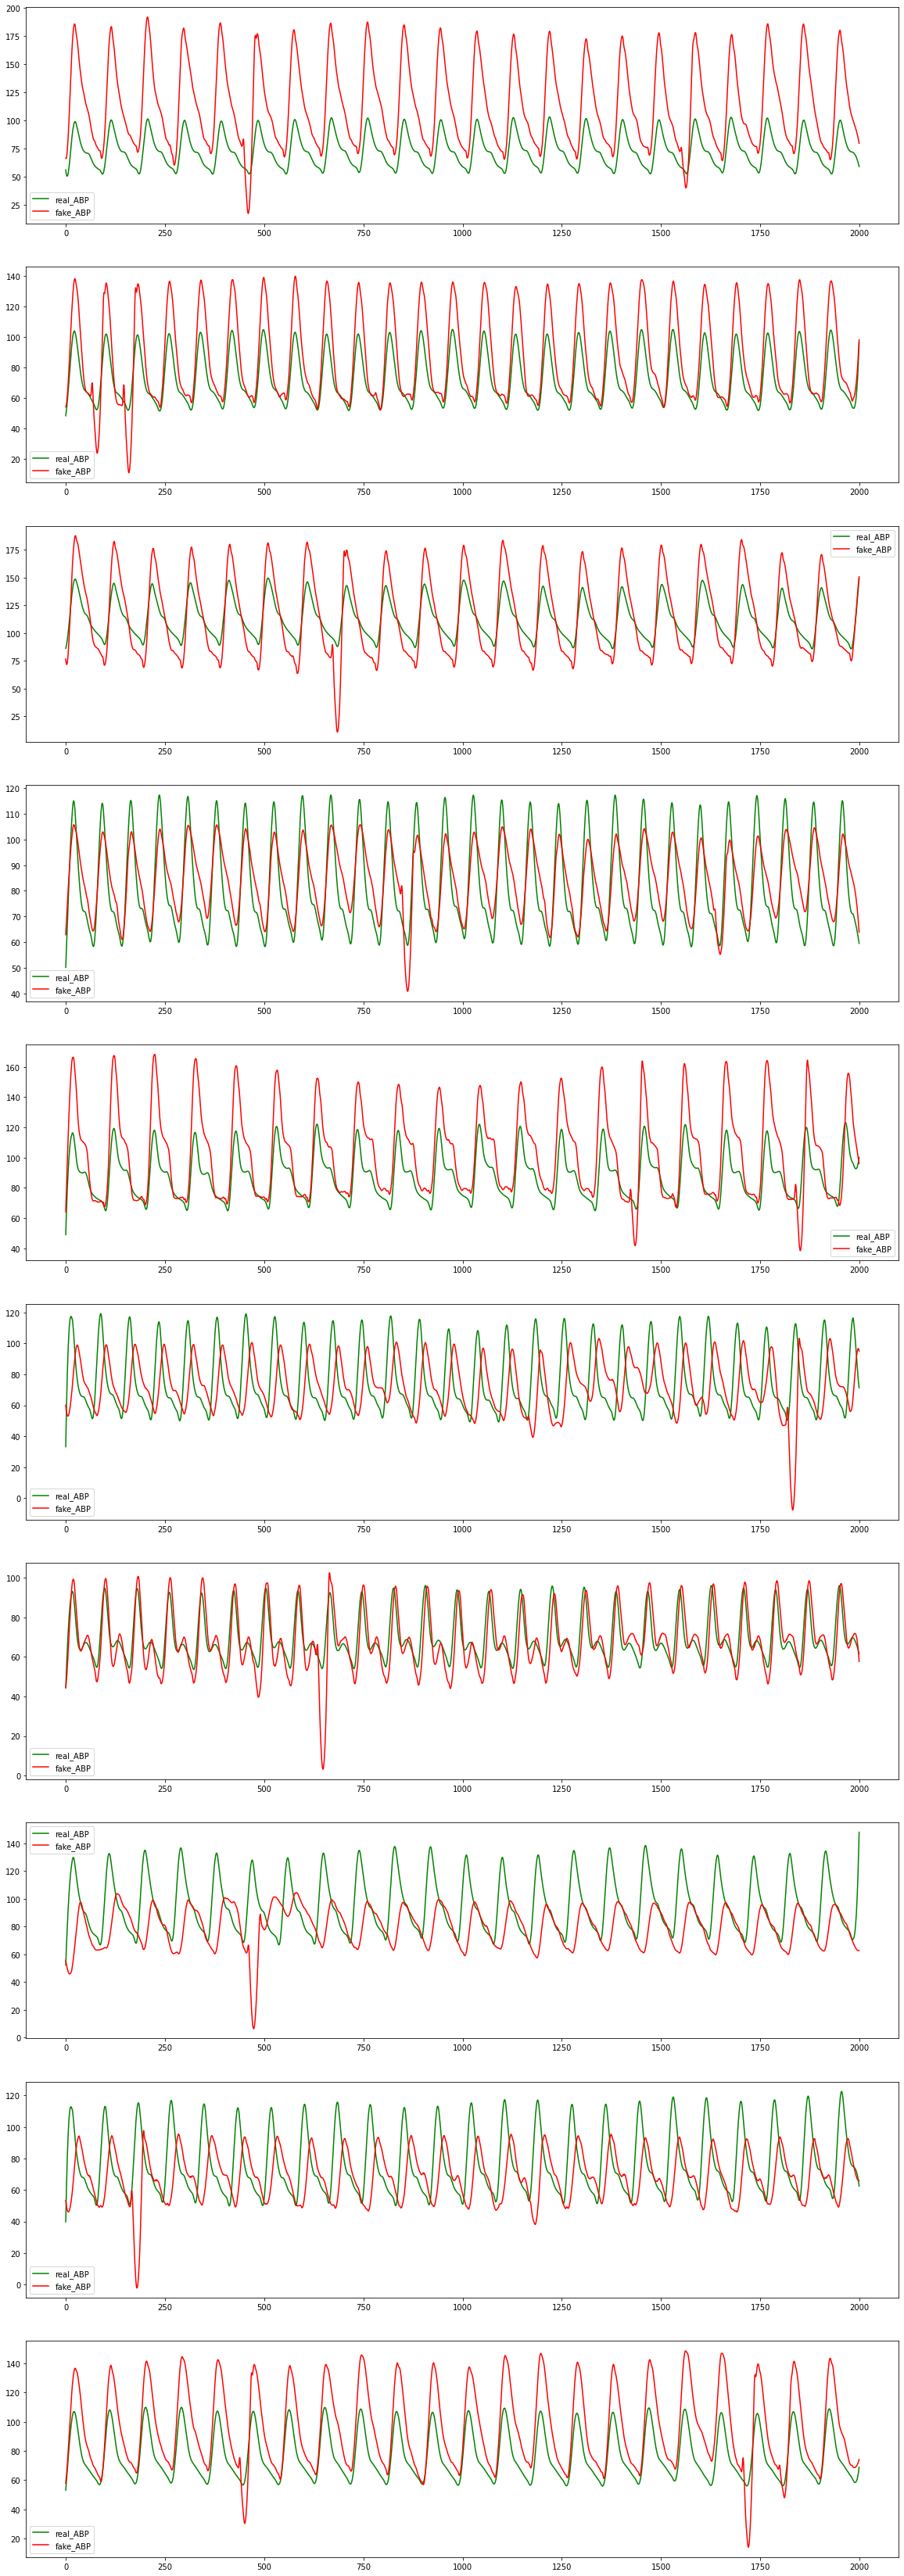

In [25]:
from scipy.signal import savgol_filter
fake_filtered_abp = savgol_filter(fake_abp_sets, 31, 3)

plt.figure(figsize=(20,60))
for i in range(1,11):
  plt.subplot(10,1,i)
  plt.plot(real_abp_sets[i], color='g', label='real_ABP')
  plt.plot(fake_filtered_abp[i], color='r', label='fake_ABP')
  plt.legend()

plt.savefig('/content/drive/MyDrive/snuh/output/reduce/graph/compared_abp_after_filter.png')

## Evaluation

### Mean Error

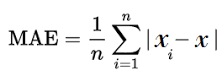

<pre>
MAE = mean absolute error 
yi = prediction
xi = true value
n = total number of data points
</pre>


### Standard Deviation
<img src="https://www.gstatic.com/education/formulas2/443397389/en/population_standard_deviation.svg">
<pre>
std = poplulation standard deviation
N = size of the population
xi = each value from the population
u = population mean
</pre>

<pre>
DBP - 이완기혈압 (diastolic blood pressure) = min(ABP)
SBP - 수축기혈압 (systolic blood Pressure) = max(ABP)
PP - 맥압 (Pulse Pressure; PP) = (SBP - DBP)
MAP - 평균혈압 (Mean Arterial Pressure) =  DP + 1/3(SP – DP)
</pre>

In [25]:
!pip install pyvital

In [ ]:
import pyvital

N = len(real_abp_sets)

def findMinMax(datasets):
  return (np.max(datasets), np.min(datasets))

tot_mae_sbp_fake = 0
tot_mae_sbp_filtered = 0
tot_mae_dbp_fake = 0
tot_mae_dbp_filtered = 0
tot_mae_map_fake = 0
tot_mae_map_filtered = 0

for i in range(N):
  # Find SBP and DBP -----------------------------------------------------------
  # Extract [SBP, DBP] index
  real_peaks = pyvital.arr.detect_peaks(real_abp_sets[i], 100) 
  fake_peaks = pyvital.arr.detect_peaks(fake_abp_sets[i], 100)
  filtered_peaks = pyvital.arr.detect_peaks(fake_filtered_abp[i], 100)

  # SBP --------------------------------------------------------------
  # Calculate avg error for SBP
  local_mae_sbp = np.mean(abs(fake_abp_sets[i][fake_peaks[0]] - real_abp_sets[i][real_peaks[0]]))
  local_mae_sbp_f = np.mean(abs(fake_filtered_abp[i][fake_peaks[0]] - real_abp_sets[i][real_peaks[0]]))
  tot_mae_sbp_fake += local_mae_sbp
  tot_mae_sbp_filtered += local_mae_sbp_f

  # DBP --------------------------------------------------------------
  # Calculate avg error for DBP
  local_mae_dbp = np.mean(fake_abp_sets[i][fake_peaks[1]])
  local_mae_dbp_f = np.mean(fake_filtered_abp[i][fake_peaks[1]])
  tot_mae_dbp_fake += local_mae_dbp
  tot_mae_dbp_filtered += local_mae_dbp_f

  # local_sbp---------------------------------------------------------
  local_sbp = np.mean(fake_abp_sets[i][fake_peaks[0]])
  local_sbp_f = np.mean(fake_filtered_abp[i][fake_peaks[0]])
  # local_dbp---------------------------------------------------------
  local_dbp = np.mean(fake_abp_sets[i][fake_peaks[1]])
  local_dbp_f = np.mean(fake_filtered_abp[i][fake_peaks[1]])

  # MAP --------------------------------------------------------------
  # DP + 1/3(SP – DP)  
  local_mae_map = (local_dbp + 1/3(local_sbp - local_dbp))
  local_mae_map_f = (local_dbp_f + 1/3(local_sbp_f - local_dbp_f))
  tot_mae_map_fake += local_mae_map
  tot_mae_map_filtered += local_mae_map_f

# Overall SBP, DBP, MAP ----------------------------------------------
MAE_SBP_fake = tot_mae_sbp_fake / N
MAE_SBP_filtered = tot_mae_sbp_filtered / N

MAE_DBP_fake = tot_mae_dbp_fake / N
MAE_DBP_filtered = tot_mae_dbp_filtered / N

MAE_MAP_fake = tot_mae_map_fake / N
MAE_MAP_filtered = tot_mae_map_filtered / N

print("Basic Fake------------------------\
       MAE SBP: {:.4f}, MAE DBP: {:.4f}, MAE MAP: {:.4f}".format(
       MAE_SBP_fake, MAE_DBP_fake, MAE_MAP_fake))
print("Filtered Fake------------------------\
       MAE SBP: {:.4f}, MAE DBP: {:.4f}, MAE MAP: {:.4f}".format(
       MAE_SBP_filtered, MAE_DBP_filtered, MAE_MAP_filtered))


In [26]:
N = len(real_abp_sets)

def findMinMax(datasets):
  return (np.max(datasets), np.min(datasets))

tot_mae_sbp_fake = 0
tot_mae_sbp_filtered = 0
tot_mae_dbp_fake = 0
tot_mae_dbp_filtered = 0
tot_mae_map_fake = 0
tot_mae_map_filtered = 0

for i in range(N):
  # Extract [SBP, DBP] index
  real_abp = pyvital.arr.exclude_undefined(real_abp_sets[i])
  real_peaks = pyvital.arr.detect_peaks(real_abp, 100) 
  fake_peaks = pyvital.arr.detect_peaks(fake_abp_sets[i], 100)
  filtered_peaks = pyvital.arr.detect_peaks(fake_filtered_abp[i], 100)

  # Find SBP and DBP -----------------------------------------------------------
  # local_sbp ---------------------------------------------------------
  local_sbp_r = np.mean(real_abp_sets[i][real_peaks[0]])
  local_sbp = np.mean(fake_abp_sets[i][fake_peaks[0]])
  local_sbp_f = np.mean(fake_filtered_abp[i][fake_peaks[0]])

  # local_dbp ---------------------------------------------------------
  local_dbp_r = np.mean(real_abp_sets[i][real_peaks[1]])
  local_dbp = np.mean(fake_abp_sets[i][fake_peaks[1]])
  local_dbp_f = np.mean(fake_filtered_abp[i][fake_peaks[1]])

  # local_map ---------------------------------------------------------  
  local_map_r = (local_dbp_r + 1/3(local_sbp_r - local_dbp_r))
  local_map = (local_dbp + 1/3(local_sbp - local_dbp))
  local_map_f = (local_dbp_f + 1/3(local_sbp_f - local_dbp_f))

  # local MAE
  tot_mae_sbp_fake += abs(local_sbp - local_sbp_r)
  tot_mae_sbp_filtered += abs(local_sbp_f - local_sbp_r)

  tot_mae_dbp_fake += abs(local_dbp - local_dbp_r)
  tot_mae_dbp_filtered += abs(local_dbp_f - local_dbp_r)

  tot_mae_map_fake += abs(local_map - local_map_r)
  tot_mae_map_filtered += abs(local_map_f - local_map_r)


# Overall SBP, DBP, MAP ----------------------------------------------
MAE_SBP_fake = tot_mae_sbp_fake / N
MAE_SBP_filtered = tot_mae_sbp_filtered / N

MAE_DBP_fake = tot_mae_dbp_fake / N
MAE_DBP_filtered = tot_mae_dbp_filtered / N

MAE_MAP_fake = tot_mae_map_fake / N
MAE_MAP_filtered = tot_mae_map_filtered / N

print("Basic Fake------------------------\
       MAE SBP: {:.4f}, MAE DBP: {:.4f}, MAE MAP: {:.4f}".format(
       MAE_SBP_fake, MAE_DBP_fake, MAE_MAP_fake))
print("Filtered Fake------------------------\
       MAE SBP: {:.4f}, MAE DBP: {:.4f}, MAE MAP: {:.4f}".format(
       MAE_SBP_filtered, MAE_DBP_filtered, MAE_MAP_filtered))


NameError: ignored